In [1]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [1]:
%reload_ext autoreload
%autoreload 2

# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW9


---
__Name:__  Sahab Aslam   
__Class:__ MIDS w261 (Section *Your Section Goes Here*, e.g., Fall 2016 Group 1)     
__Email:__  sahab@iSchool.Berkeley.edu     
__Unit 9:__   

__Due Time:__ HW9 is due on Tuesday 11/15/2016. 


# Table of Contents <a name="TOC"></a> 

1.  [HW Intructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW  Problems](#3)   
    1.0.  [HW9.0](#1.0)   
    1.0.  [HW9.1](#1.1)   
    1.2.  [HW9.2](#1.2)   
    1.3.  [HW9.3](#1.3)    
    1.4.  [HW9.4](#1.4)    
    1.5.  [HW9.5](#1.5)    
    1.5.  [HW9.6](#1.6)    
   

<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale
DATSCIW261 ASSIGNMENT #9

Version 2016-11-01 

### INSTRUCTIONS for SUBMISSIONS
Please use the following form for HW submission:

https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 


### IMPORTANT

HW9 can be completed locally on your computer for most part but will require a cluster of computers for the bigger wikipedia dataset.

### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* See async and live lectures for this week
* Data-intensive text processing with MapReduce. San Rafael, CA: Morgan & Claypool Publishers. Chapter 5. 



<a name="3">
# HW Problems
[Back to Table of Contents](#TOC)

<h2 style="color:darkblue">HW 9 Dataset</h2>

Note that all referenced files life in the enclosing directory. [Checkout the Data subdirectory on Dropbox](https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0) or the AWS S3 buckets (details contained each question). 

## 3.  HW9.0  Short answer questions<a name="1.0"></a>
[Back to Table of Contents](#TOC)

__ What is PageRank and what is it used for in the context of web search?__



<hr>

__ What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the Steady State Distibution? __



<hr>

__ OPTIONAL: In topic-specific pagerank, how can we ensure that the irreducible property is satifsied? (HINT: see HW9.4) __



<hr>


In [ ]:
#Page Rank:
#Probability for jumping out

## 3.  HW9.1  MRJob implementation of basic PageRank <a name="1.1"></a>
[Back to Table of Contents](#TOC)

Write a basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input (as explored in HW 7).

Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).


[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability d,one of the hyperlinks in the current page. This probability is represented by a so-called *damping factor* d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page]

As you build your code, use the data located here :

In the Data Subfolder for HW7 on Dropbox (same dataset as HW7) with the same file name. 
> Dropbox: https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

Or on Amazon: 

> s3://ucb-mids-mls-networks/PageRank-test.txt

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image in the [Wikipedia article](https://en.wikipedia.org/wiki/PageRank)
and here for reference are the corresponding PageRank probabilities:
<pre>

A, 0.033
B, 0.384
C, 0.343
D, 0.039
E, 0.081
F, 0.039
G, 0.016
H, 0.016
I, 0.016
J, 0.016
K, 0.016

</pre>

In [3]:
!head PageRank-test.txt

B	{'C': 1}
C	{'B': 1}
D	{'A': 1, 'B': 1}
E	{'D': 1, 'B': 1, 'F': 1}
F	{'B': 1, 'E': 1}
G	{'B': 1, 'E': 1}
H	{'B': 1, 'E': 1}
I	{'B': 1, 'E': 1}
J	{'E': 1}
K	{'E': 1}


<h2 style="color:darkgreen"> HW 9.1 Implementation </h2>

In [99]:
%%writefile PageRank_Initialize.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.step import MRStep
from ast import literal_eval

class initialize(MRJob):
    
    nodesWithNeighbor = set()
    allnodes = set()
    nodesWithOUTNeighbor = set()
    total = 0.0
    totalNodes = 0
    tn = 0
    
    def mapper_makegraph(self,_,line):

        link = line.strip().split('\t')
        node = link[0]
        neighbors = literal_eval(link[1])
        #yield the relationship as it is
        yield node,neighbors
        #print node, neighbors
        self.nodesWithNeighbor.add(node)
        self.allnodes |= set(neighbors)
        self.nodesWithOUTNeighbor = self.allnodes - self.nodesWithNeighbor

        #make sure all nodes get out, like A->none, but C->A
        for eachnode in self.nodesWithOUTNeighbor:
            yield eachnode, 1

    def reducer_makegraph(self,node,neighbors):
        edges = {}

        for neighbor in neighbors:
            if neighbor != 1:
                edges = neighbor
        yield node, edges

    def combiner_norm(self, key, values):
        totalNodes = len((self.nodesWithNeighbor.union(self.nodesWithOUTNeighbor)).union(self.allnodes))
        for val in values:
            yield key, (val, 1 / totalNodes)

    def reducer_norm(self, key, values):
        totalNodes = len((self.nodesWithNeighbor.union(self.nodesWithOUTNeighbor)).union(self.allnodes))
        for val in values:
            yield key, (val, 1 / totalNodes)


    def steps(self):
        return [
            MRStep(mapper=self.mapper_makegraph,
                   reducer=self.reducer_makegraph),
            MRStep(
                   reducer=self.reducer_norm,
                   jobconf={'mapred.reduce.tasks': 1})
        ]

if __name__ == '__main__':
    initialize.run()

Overwriting PageRank_Initialize.py


In [107]:
from PageRank_Initialize import initialize

mr_job = initialize(args=["PageRank-test.txt", '--no-strict-protocols', '--output-dir', "PageRank-output"])#, '-r', 'hadoop', '--hadoop-home', '/usr/',
                                 #'--output-dir', "PageRank-output.txt"])

with mr_job.make_runner() as runner:
        runner.run()

        for line in runner.stream_output():
            print mr_job.parse_output_line(line)

('A', [{}, 0.08333333333333333])
('B', [{'C': 1}, 0.08333333333333333])
('C', [{'B': 1}, 0.08333333333333333])
('D', [{'A': 1, 'B': 1}, 0.08333333333333333])
('E', [{'B': 1, 'D': 1, 'F': 1}, 0.08333333333333333])
('F', [{'B': 1, 'E': 1}, 0.08333333333333333])
('G', [{'B': 1, 'E': 1}, 0.08333333333333333])
('H', [{'B': 1, 'E': 1}, 0.08333333333333333])
('I', [{'B': 1, 'E': 1}, 0.08333333333333333])
('J', [{'E': 1}, 0.08333333333333333])
('K', [{'E': 1}, 0.08333333333333333])


In [163]:
!head PageRank-output/part-00000

"A"	[{}, 0.08333333333333333]
"B"	[{"C": 1}, 0.08333333333333333]
"C"	[{"B": 1}, 0.08333333333333333]
"D"	[{"A": 1, "B": 1}, 0.08333333333333333]
"E"	[{"B": 1, "D": 1, "F": 1}, 0.08333333333333333]
"F"	[{"B": 1, "E": 1}, 0.08333333333333333]
"G"	[{"B": 1, "E": 1}, 0.08333333333333333]
"H"	[{"B": 1, "E": 1}, 0.08333333333333333]
"I"	[{"B": 1, "E": 1}, 0.08333333333333333]
"J"	[{"E": 1}, 0.08333333333333333]


In [212]:
%%writefile PageRank.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol

class PageRank(MRJob):
    
    m=0.0 #dangling mass

    
    def configure_options(self):
        super(iterate, self).configure_options()
        self.add_passthrough_option('--numNodes', default=1, type='int')
        self.add_passthrough_option('--damp', default=0.85, type='float')
        self.add_passthrough_option('--iterations', default=1, type='int')
    
    INPUT_PROTOCOL = JSONProtocol
    
    
    def mapper(self, key, value):

        #let's not call len three times
        totalNeighbors = len(value[0])
        

        if totalNeighbors > 0:
            for neighbor in value[0]:
                yield neighbor, value[1]/ totalNeighbors
                       
        else:
            yield '*', value[1]

        yield key, value[0]
     

    
    def reducer_dist(self, key, values):
        
        pageRank = 0.0
        for val in values:
            if isinstance(val, float):
                pageRank += val
                neighbors = {}
            else:
                neighbors = val
        if key == '*':
            self.m = pageRank
        else:
            a = self.options.damp
            n = self.options.numNodes
            newPageRank = (1 - a) / n + a * (self.m / n + pageRank)
            yield key, (neighbors, newPageRank)


    
    def steps(self):
        return ([
            MRStep(mapper=self.mapper,
                   reducer=self.reducer_dist, 
                   jobconf={'mapred.reduce.tasks': 1})
            ] * self.options.iterations)

if __name__ == '__main__':
    PageRank.run()


Overwriting PageRank_Iterate.py


In [213]:
from PageRank import PageRank

mr_job = PageRank(args=["PageRank-output/part-00000", '--no-strict-protocols',  '--numNodes=11',
                               '--damp=.85', '--iterations=30'])



with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            print mr_job.parse_output_line(line)


('A', [{}, 0.032781493897796145])
('B', [{'C': 1}, 0.3833517886180316])
('C', [{'B': 1}, 0.34332354472412263])
('D', [{'A': 1, 'B': 1}, 0.039087092961339664])
('E', [{'B': 1, 'D': 1, 'F': 1}, 0.08088569455310861])
('F', [{'B': 1, 'E': 1}, 0.039087092961339664])
('G', [{'B': 1, 'E': 1}, 0.01616947913027243])
('H', [{'B': 1, 'E': 1}, 0.01616947913027243])
('I', [{'B': 1, 'E': 1}, 0.01616947913027243])
('J', [{'E': 1}, 0.01616947913027243])
('K', [{'E': 1}, 0.01616947913027243])


<h2 style="color:darkgreen">  HW 9.1 Analysis </h2>




<br><br>

## 3.  HW9.2: Exploring PageRank teleportation and network plots <a name="1.2"></a>
[Back to Table of Contents](#TOC)


* In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
* Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha, so that each nodes radius is proportional to its PageRank score. 
* In particular you should do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. 
* Note your plots should look like the following: https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

In [216]:
from PageRank_Iterate import iterate

mr_job = iterate(args=["PageRank-output/part-00000", '--no-strict-protocols',  '--numNodes=11',
                               '--damp=1.0', '--iterations=30', '--output-dir', "PageRank-damp/100"])
with mr_job.make_runner() as runner:
        runner.run()
        #for line in runner.stream_output():
           # print mr_job.parse_output_line(line)
            
mr_job = iterate(args=["PageRank-output/part-00000", '--no-strict-protocols',  '--numNodes=11',
                               '--damp=.85', '--iterations=30', '--output-dir', "PageRank-damp/85"])
with mr_job.make_runner() as runner:
        runner.run()
        #for line in runner.stream_output():
          #  print mr_job.parse_output_line(line)
            
mr_job = iterate(args=["PageRank-output/part-00000", '--no-strict-protocols',  '--numNodes=11',
                               '--damp=.75', '--iterations=30', '--output-dir', "PageRank-damp/75"])
with mr_job.make_runner() as runner:
        runner.run()
        #for line in runner.stream_output():
            #print mr_job.parse_output_line(line)
            
mr_job = iterate(args=["PageRank-output/part-00000", '--no-strict-protocols',  '--numNodes=11',
                               '--damp=.5', '--iterations=30', '--output-dir', "PageRank-damp/5"])
with mr_job.make_runner() as runner:
        runner.run()
       # for line in runner.stream_output():
           # print mr_job.parse_output_line(line)
            
mr_job = iterate(args=["PageRank-output/part-00000", '--no-strict-protocols',  '--numNodes=11',
                               '--damp=.25', '--iterations=30', '--output-dir', "PageRank-damp/25"])
with mr_job.make_runner() as runner:
        runner.run()
       # for line in runner.stream_output():
           # print mr_job.parse_output_line(line)
            
mr_job = iterate(args=["PageRank-output/part-00000", '--no-strict-protocols',  '--numNodes=11',
                               '--damp=0.0', '--iterations=30', '--output-dir', "PageRank-damp/00"])
with mr_job.make_runner() as runner:
        runner.run()
        #for line in runner.stream_output():
           # print mr_job.parse_output_line(line)

('A', [{}, 1.5136376242248933e-07])
('B', [{'C': 1}, 0.3532106619083788])
('C', [{'B': 1}, 0.5634551225187382])
('D', [{'A': 1, 'B': 1}, 1.731257387271089e-07])
('E', [{'B': 1, 'D': 1, 'F': 1}, 2.7055242931468764e-07])
('F', [{'B': 1, 'E': 1}, 1.731257387271089e-07])
('G', [{'B': 1, 'E': 1}, 2.2814376025993038e-08])
('H', [{'B': 1, 'E': 1}, 2.2814376025993038e-08])
('I', [{'B': 1, 'E': 1}, 2.2814376025993038e-08])
('J', [{'E': 1}, 2.2814376025993038e-08])
('K', [{'E': 1}, 2.2814376025993038e-08])
('A', [{}, 0.032781493897796145])
('B', [{'C': 1}, 0.3833517886180316])
('C', [{'B': 1}, 0.34332354472412263])
('D', [{'A': 1, 'B': 1}, 0.039087092961339664])
('E', [{'B': 1, 'D': 1, 'F': 1}, 0.08088569455310861])
('F', [{'B': 1, 'E': 1}, 0.039087092961339664])
('G', [{'B': 1, 'E': 1}, 0.01616947913027243])
('H', [{'B': 1, 'E': 1}, 0.01616947913027243])
('I', [{'B': 1, 'E': 1}, 0.01616947913027243])
('J', [{'E': 1}, 0.01616947913027243])
('K', [{'E': 1}, 0.01616947913027243])
('A', [{}, 0.0463

In [348]:
# Function to draw graph using networkx
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
def pagerankgraph(filename, damping):
    
    G=nx.DiGraph()
    numberNodes = 11
    nodes={}
    with open (filename,'r') as f:
        for line in f:
            node, info = line.strip().split('\t')
            node = eval(node)
            info = eval(info)
            G.add_node(node)
            PageRank = info[1]
            neighbors = info[0]
            for edge in neighbors:
                G.add_edge(node, edge)
            
            nodes[node] = round(PageRank*100, 0)

    print "\nPage Ranks for the damping effect", damping*1.0/100
    plt.figure(figsize=(10, 10))
    #node_labels=list(nodes.keys())
    #labels = [str(key) + " " + str(val) for key, val in nodes.items()]
    #print labels
    labels ={}
    for node, rank in nodes.items():
        labels[node] =  str(node) + " " + str(rank) 

    ranks =[nodes[node]*10000/max(nodes.values()) for node in nodes]
    pos = nx.circular_layout(G)
    nx.draw_networkx_labels(G,pos,labels)
    nx.draw(G,pos, node_color = ranks, node_size=ranks,cmap=plt.cm.gist_rainbow ,edge_cmap=plt.cm.BuGn,alpha=0.6)
    plt.show()


Page Ranks for the damping effect 0.0


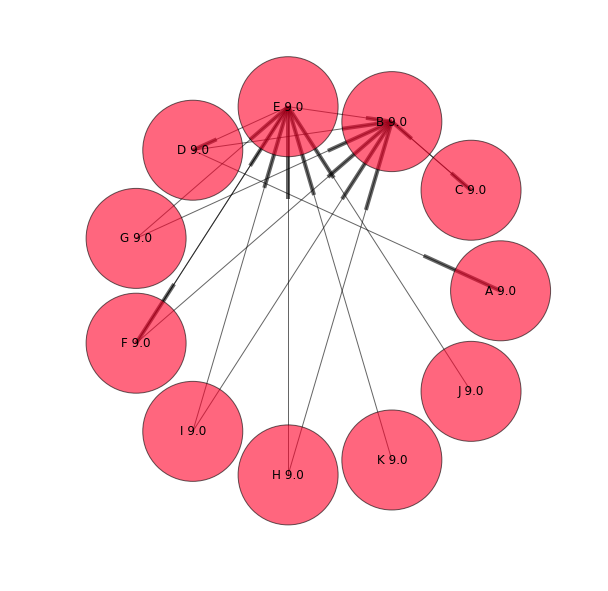


Page Ranks for the damping effect 0.25


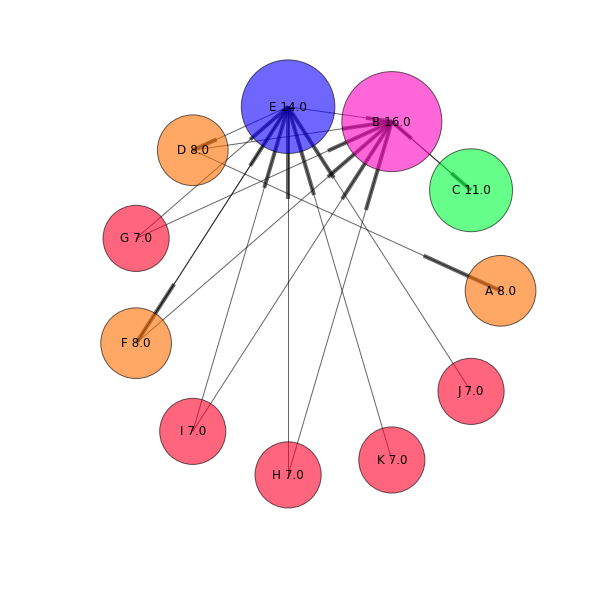


Page Ranks for the damping effect 0.05


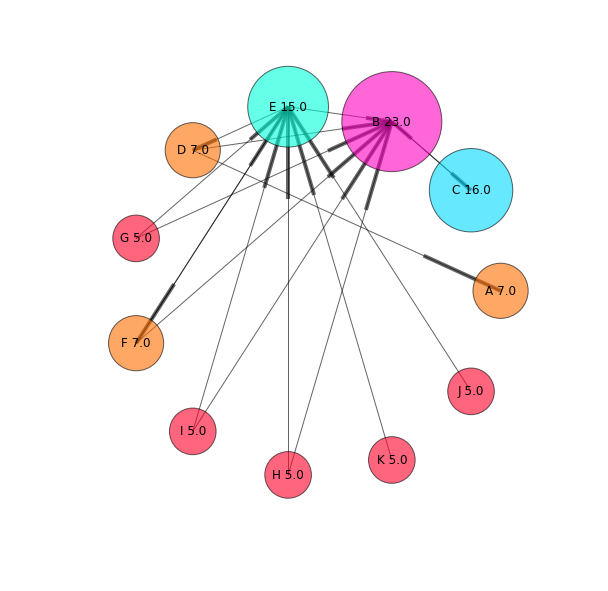


Page Ranks for the damping effect 0.75


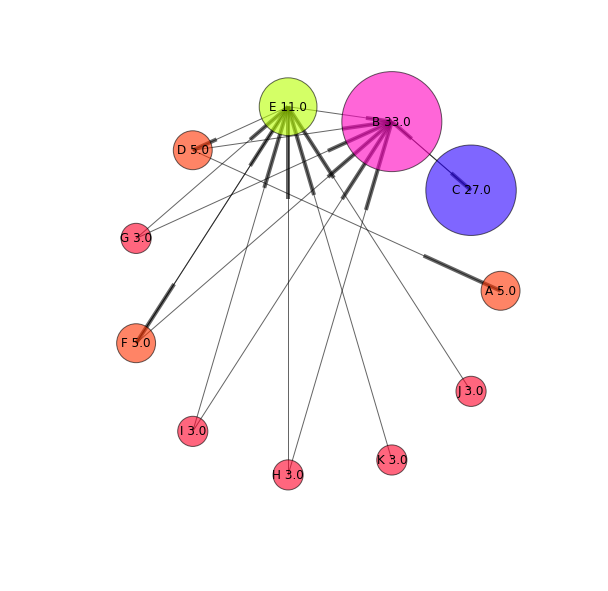


Page Ranks for the damping effect 0.85


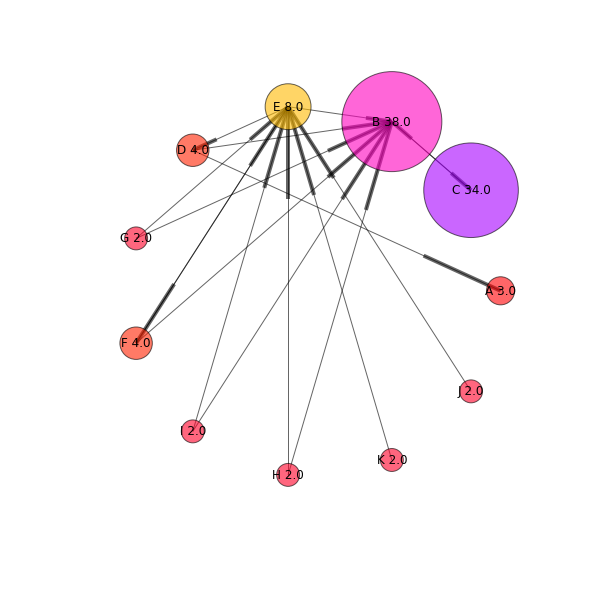


Page Ranks for the damping effect 1.0


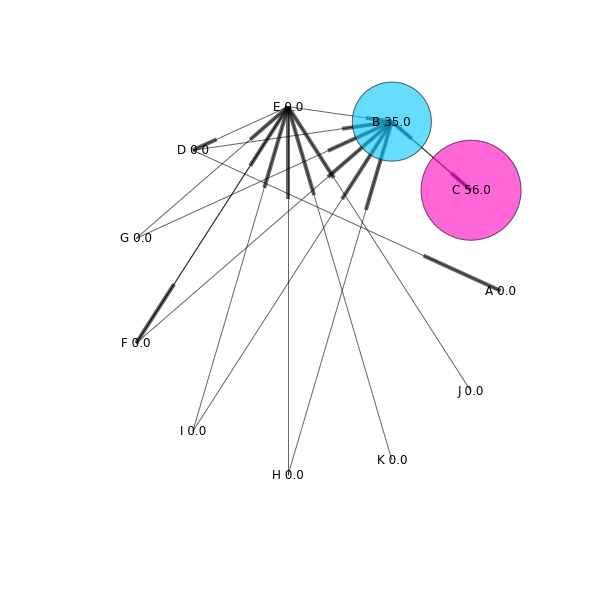

In [349]:
dampingfactors = [0,25,5,75, 85, 100]
for i in range(6):
    filename = "PageRank-damp/" + str(dampingfactors[i])  + "/part-00000"
    pagerankgraph(filename, dampingfactors[i])

In [234]:
!head PageRank-damp/100/part-00000

"A"	[{}, 1.5136376242248933e-07]
"B"	[{"C": 1}, 0.3532106619083788]
"C"	[{"B": 1}, 0.5634551225187382]
"D"	[{"A": 1, "B": 1}, 1.731257387271089e-07]
"E"	[{"B": 1, "D": 1, "F": 1}, 2.7055242931468764e-07]
"F"	[{"B": 1, "E": 1}, 1.731257387271089e-07]
"G"	[{"B": 1, "E": 1}, 2.2814376025993038e-08]
"H"	[{"B": 1, "E": 1}, 2.2814376025993038e-08]
"I"	[{"B": 1, "E": 1}, 2.2814376025993038e-08]
"J"	[{"E": 1}, 2.2814376025993038e-08]



<h2 style="color:darkgreen"> HW 9.2 Implementation </h2>

In [ ]:
from PageRank_Initialize import initialize

mr_job = initialize(args=["all-pages-indexed-in.txt", '--no-strict-protocols', '--output-dir', "wiki-output"])#, '-r', 'hadoop', '--hadoop-home', '/usr/',
                                 #'--output-dir', "PageRank-output.txt"])
#mr_job = initialize(args=["all-pages-indexed-in.txt", '--no-strict-protocols', '--output-dir', "wiki-output", 
                       #   '-r', 'hadoop', '--hadoop-home', '/usr/'])
with mr_job.make_runner() as runner:
        runner.run()

        for line in runner.stream_output():
            print mr_job.parse_output_line(line)

In [351]:
## Drivers & Runners
!head all-pages-indexed-in.txt

90	{'8430954': 2}
212	{'3351482': 1, '3635586': 1}
332	{'8996949': 1}
428	{'3937326': 1, '14055878': 1}
490	{'14055878': 1}
535	{'594535': 1}
725	{'4852601': 1}
759	{'4852601': 1}
849	{'4852601': 1}
874	{'4852601': 1}


In [3]:
## Run Scripts, S3 Sync

<h2 style="color:darkgreen">  HW 9.2 Analysis </h2>




<br><br>

## 3.  HW9.3: Applying PageRank to the Wikipedia hyperlinks network <a name="1.3"></a>
[Back to Table of Contents](#TOC)

<
* Run your PageRank implementation on the Wikipedia dataset for 5 iterations, and display the top 100 ranked nodes (with alpha = 0.85).
* Run your PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15).
* Have the top 100 ranked pages changed? Comment on your findings. 
* Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  


<h2 style="color:darkgreen"> HW 9.3 Implementation </h2>

In [1]:
## Code goes here

In [2]:
## Drivers & Runners

In [3]:
## Run Scripts, S3 Sync

 <h2 style="color:darkgreen">  HW 9.3 Analysis </h2>




<br><br>

## 3.  HW9.4: Topic-specific PageRank implementation using MRJob <a name="1.4"></a>
[Back to Table of Contents](#TOC)

Modify your PageRank implementation to produce a topic specific PageRank implementation, as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.   
This caveat lies in footnote 3 on page 3:
```
	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.
```
and must be adhered to for convergence to be guaranteed.   

Run topic specific PageRank on the following randomly generated network of 100 nodes:

> s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

> s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors (one for the vanilla PageRank implementation in 9.1, and one for each topic with the topic specific implementation). Print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the requirements for irreducibility with topic-specific PageRank. In particular, the literature ensures irreducibility by requiring that nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed separately for each of the (10) topics.

So, instead of using this method for irreducibility, please comment on why the literature's method is difficult to implement, and what what extra computation it will require.   

Then for your code, please use the alternative, non-uniform damping vector:

```
vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj
```
for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes. If beta > 0.5, PageRank is topic-sensitive, and if beta < 0.5, the PageRank is anti-topic-sensitive. For any value of beta irreducibility should hold, so please try beta=0.99, and perhaps some other values locally, on the smaller networks.

<h2 style="color:darkgreen"> HW 9.4 Implementation </h2>

In [1]:
## Code goes here

In [2]:
## Drivers & Runners

In [3]:
## Run Scripts, S3 Sync

<h2 style="color:darkgreen">  HW 9.4 Analysis </h2>




<br><br>

<center><div class='jumbotron'><h3 style='color:darkblue'>---------  OPTIONAL QUESTIONS SECTION --------</h3></div></center>

## 3.  HW9.5: (OPTIONAL) Applying topic-specific PageRank to Wikipedia <a name="1.5"></a>
[Back to Table of Contents](#TOC)


Here you will apply your topic-specific PageRank implementation to Wikipedia, defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10, so that there are 10 topics. 

* Once again, print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses. Run for 10 iterations.
* Plot the pagerank values for the top 100 pages resulting from the 5 iterations run in HW 9.3. 
* Then plot the pagerank values for the same 100 pages that result from the topic specific pagerank after 10 iterations run. 
* Comment on your findings. 

<h2 style="color:darkgreen"> HW 9.5 Implementation </h2>

In [1]:
## Code goes here

In [2]:
## Drivers & Runners

In [3]:
## Run Scripts, S3 Sync

<h2 style="color:darkgreen">  HW 9.5 Analysis </h2>




<br><br>

## 3.  HW9.6:  (OPTIONAL) TextRank <a name="1.6"></a>
[Back to Table of Contents](#TOC)


* What is TextRank? Describe the main steps in the algorithm. Why does TextRank work?
* Implement TextRank in MrJob for keyword phrases (not just unigrams) extraction using co-occurrence based similarity measure with with sizes of N = 2 and 3. And evaluate your code using the following example using precision, recall, and FBeta (Beta=1):
```
"Compatibility of systems of linear constraints over the set of natural numbers
Criteria of compatibility of a system of linear Diophantine equations, strict 
inequations, and nonstrict inequations are considered. Upper bounds for
components of a minimal set of solutions and algorithms of construction of 
minimal generating sets of solutions for all types of systems are given. 
These criteria and the corresponding algorithms for constructing a minimal 
supporting set of solutions can be used in solving all the considered types of 
systems and systems of mixed types." 
```
* The extracted keywords should in the following set:
```
linear constraints, linear diophantine equations, natural numbers, non-strict inequations, strict inequations, upper bounds
```

<h2 style="color:darkgreen"> HW 9.6 Implementation </h2>

In [1]:
## Code goes here

In [2]:
## Drivers & Runners

In [3]:
## Run Scripts, S3 Sync

<h2 style="color:darkgreen">  HW 9.6 Analysis </h2>




<br><br>

<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HWK 9 --------</h2></div></center>